# Non-supervised gating of the data via the front and side scattering.

In [1]:
import os
import glob
# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy

import mwc_induction_utils as mwc

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Seaborn, useful for graphics
import seaborn as sns

# Import Bokeh modules for interactive plotting
import bokeh.io
import bokeh.mpl
import bokeh.plotting

# favorite Seaborn settings for notebooks
rc={'lines.linewidth': 2, 
    'axes.labelsize' : 16, 
    'axes.titlesize' : 18,
    'axes.facecolor' : 'F4F3F6',
    'axes.edgecolor' : '000000',
    'axes.linewidth' : 1.2,
    'xtick.labelsize' : 13,
    'ytick.labelsize' : 13,
    'grid.linestyle' : ':',
    'grid.color' : 'a6a6a6'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)
sns.set_palette("deep", color_codes=True)

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

# Datashader to plot lots of datapoints
import datashader as ds
from datashader.bokeh_ext import InteractiveImage
from datashader.utils import export_image
from IPython.core.display import HTML, display

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()
bokeh.plotting.output_notebook()

Loading BokehJS ...

Loading BokehJS ...

# Plotting all of the data with datashader

Trying to find a reliable automatic thresholding of the data is not easy. So far our criteria has been based in plotting 5% of the data on a `FSC-A` vs `SSC-A` scatter plot and deciding arbitrary cutoffs for the data points.

But as we will show using Python's amazing `datashader` library for plotting large data sets this undersampling can be quite misleading.

Let's first read an example data set. We will be working with the lacI titration data set generated on `20160804`.

In [2]:
# define variables to use over the script
date = 20160725
username = 'mrazomej'

# list the directory with the data
datadir = '../../data/flow/csv/'
files = np.array(os.listdir(datadir))
csv_bool = np.array([str(date) in f and 'csv' in f for f in files])
files = files[np.array(csv_bool)]

df_example = pd.read_csv(datadir + files[1])

Now in order to use `datashader` in an interactive `Bokeh` plot let's define a `base_plot` function to initialize a Bokeh plot.

In [3]:
def base_plot(df, x_col, y_col, log=False):
    # Define the range to plot chekcing if it is a log scale or not
    if log:
        x_range = (np.min(np.log10(df[x_col])), 
                   np.max(np.log10(df[x_col])))
        y_range = (np.min(np.log10(df[y_col])), 
                   np.max(np.log10(df[y_col])))
    else:
        x_range = (df[x_col].min(), df[x_col].max())
        y_range = (df[y_col].min(), df[y_col].max())
    # Initialize the Bokeh plot
    p = bokeh.plotting.figure(
        x_range=x_range,
        y_range=y_range,
        tools='save,pan,wheel_zoom,box_zoom,reset', 
        plot_width=500, 
        plot_height=500,
    )
    # Add all the features to the plot
    p.xgrid.grid_line_color = '#a6a6a6'
    p.ygrid.grid_line_color = '#a6a6a6'
    p.ygrid.grid_line_dash = [6, 4]
    p.xgrid.grid_line_dash = [6, 4]
    p.xaxis.axis_label = x_col
    p.yaxis.axis_label = y_col
    p.xaxis.axis_label_text_font_size = '15pt'
    p.yaxis.axis_label_text_font_size = '15pt'
    p.background_fill_color = '#F4F3F6'
    return p

With this in hand we define a simple function that takes one of our data frames and plots whichever columns we want on a 2-D scatter plot.

In [4]:
def ds_plot(df, x_col, y_col, log=False):
    if log:
        data = np.log10(df[[x_col, y_col]])
    else:
        data = df[[x_col, y_col]]
    p = base_plot(data, x_col, y_col)
    pipeline = ds.Pipeline(data, ds.Point(x_col, y_col))
    return p, pipeline

Now let's plot the channels we've been using for the thresholding, i.e. front and side scattering area.
But since we are using `datashader` we can plot **all of the data points** rather than the 5% we were using with `matplotlib`.

In [7]:
p, pipeline = ds_plot(df_example, 'FSC-A', 'SSC-A', log=True)
InteractiveImage(p, pipeline)

Let's now apply the same thresholds **we arbitrarily set by eye** on a log-log plot and plot the data. This thresholds are unique for each data set and were decided by ploting 5% of the data chosen at random on a regular `matplotlib` plot.

In [6]:
fsc_range = [5E3, 2E4]
ssc_range = [1E4, 6E4]

df_thresh = df_example[(df_example['SSC-A'] > ssc_range[0]) & \
                        (df_example['FSC-A'] > fsc_range[0]) & \
                        (df_example['SSC-A'] < ssc_range[1]) & \
                        (df_example['FSC-A'] < fsc_range[1])]


In [7]:
p, pipeline = ds_plot(df_thresh, 'FSC-A', 'SSC-A', log=True)
InteractiveImage(p, pipeline)

By this criteria it does seem that we captured the "relevant population only". But what if we were to plot this same thresholded data-set but not on a log-log plot

In [8]:
p, pipeline = ds_plot(df_thresh, 'FSC-A', 'SSC-A', log=False)
InteractiveImage(p, pipeline)

Aha! From this perspective it seemst hat we didn't really capture the body of the population but we left a huge tail on the higher end.

And on top of that these thresholds are set from experiment to experiment in a very arbritrary way which is prone to mistakes and day-to-day variability.

Could we find a way to get rid of the "supervised" thresholding and find an authomatic way to "set a gate" on our population?

# Automatic gate

Let's first plot a Kernel Density Estimation to get a sense of where does most of the data-points density is.

We will use the convenient `jointplot` from `seaborn` to make a KDE plot of these scattering.

First let's take a look at the linear scattering data.

/Users/razo/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


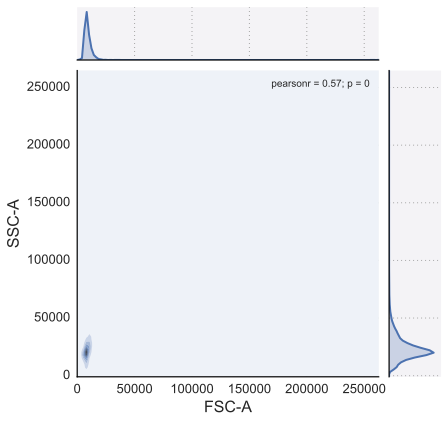

In [10]:
sns.jointplot(x='FSC-A', y='SSC-A', data=data, kind="kde");

Then the log of the scattering.

/Users/razo/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


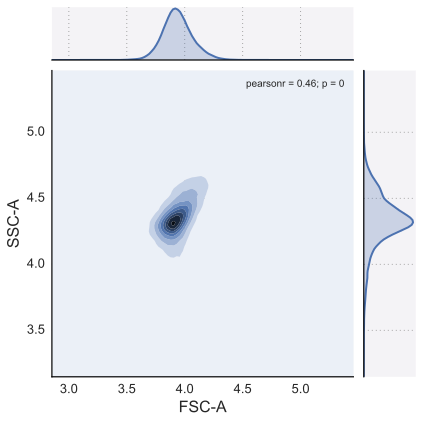

In [72]:
sns.jointplot(x='FSC-A', y='SSC-A', 
              data=np.log10(df_example[['FSC-A', 'SSC-A']]), kind="kde");

From this last plot the marginal distributions look pretty much unimodal. A possibility for setting an automatic gate could be to **fit a bivariate Gaussian distribution** to the $\log$ front and side scattering and then selecting an interval that contains a fraction $\alpha$ of the total data (for example 68% of the data).

For this we need a robut function to fit a 2D Gaussian matrix to the data. We will take advantage of the `astroML` [`fit_bivariate_normal`](http://www.astroml.org/book_figures/chapter3/fig_robust_pca.html) function to estimate the mean $\mathbf{\mu}$ and covariance matrix $\mathbf{\Sigma}$.

In [13]:
def fit_2D_gaussian(df, x_val='FSC-A', y_val='SSC-A', log=False):
    '''
    This function hacks astroML fit_bivariate_normal to return the mean and
    covariance matrix when fitting a 2D gaussian fuction to the data contained
    in the x_vall and y_val columns of the DataFrame df.
    Parameters
    ----------
    df : DataFrame.
        dataframe containing the data from which to fit the distribution
    x_val, y_val : str.
        name of the dataframe columns to be used in the function
    log : bool.
        indicate if the log of the data should be use for the fit or not
        
    Returns
    -------
    mu : tuple.
        (x, y) location of the best-fit bivariate normal
    cov : 2 x 2 array
        covariance matrix.
        cov[0, 0] = variance of the x_val column
        cov[1, 1] = variance of the y_val column
        cov[0, 1] = cov[1, 0] = covariance of the data
    '''
    if log:
        x = np.log10(df[x_val])
        y = np.log10(df[y_val])
    else:
        x = df[x_val]
        y = df[y_val]
        
    # Fit the 2D Gaussian distribution using atroML function
    mu, sigma_1, sigma_2, alpha = mwc.fit_bivariate_normal(x, y, robust=True)

    # compute covariance matrix from the standar deviations and the angle
    # that the fit_bivariate_normal function returns
    sigma_xx = ((sigma_1 * np.cos(alpha)) ** 2
                + (sigma_2 * np.sin(alpha)) ** 2)
    sigma_yy = ((sigma_1 * np.sin(alpha)) ** 2
                + (sigma_2 * np.cos(alpha)) ** 2)
    sigma_xy = (sigma_1 ** 2 - sigma_2 ** 2) * np.sin(alpha) * np.cos(alpha)
    
    # put elements of the covariance matrix into an actual matrix
    cov = np.array([[sigma_xx, sigma_xy], [sigma_xy, sigma_yy]])
    
    return mu, cov

Then to compute the interval that contains a fraction $\alpha$ of the data we can follow [this procedure](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Interval) in which for a 2D Gaussian distributiuon an elliptic region defined by
\begin{equation}
\left(\mathbf{x} - \mathbf{\mu} \right)^T \mathbf{\Sigma}^{-1} \left(\mathbf{x} - \mathbf{\mu} \right) \leq \chi^2_{2, \alpha}(p)
\end{equation}
contains $\alpha\ \times 100$ % of the data. $\chi^2_{2, \alpha}(p)$ is the  quantile function for probability $p$ of the chi-squared distribution with $2$ degrees of freedom.

Let's define a function to compute the left hand side of the inequality for our data.

In [11]:
def gauss_interval(df, mu, cov, x_val='FSC-A', y_val='SSC-A', log=False):
    '''
    Computes the of the statistic
    (x - µx)'∑(x - µx) 
    for each of the elements in df columns x_val and y_val.
    
    Parameters
    ----------
    df : DataFrame.
        dataframe containing the data from which to fit the distribution
    mu : array-like.
        (x, y) location of bivariate normal
    cov : 2 x 2 array
        covariance matrix
    x_val, y_val : str.
        name of the dataframe columns to be used in the function
    log : bool.
        indicate if the log of the data should be use for the fit or not 
    
    Returns
    -------
    statistic_gauss : array-like.
        array containing the result of the linear algebra operation:
        (x - µx)'∑(x - µx) 
    '''
    # Determine that the covariance matrix is not singular
    det = np.linalg.det(cov)
    if det == 0:
        raise NameError("The covariance matrix can't be singular")
            
    # Compute the vector x defined as [[x - mu_x], [y - mu_y]]
    if log: 
        x_vect = np.log10(np.array(df[[x_val, y_val]]))
    else:
        x_vect = np.array(df[[x_val, y_val]])
    x_vect[:, 0] = x_vect[:, 0] - mu[0]
    x_vect[:, 1] = x_vect[:, 1] - mu[1]
    
    # compute the inverse of the covariance matrix
    inv_sigma = np.linalg.inv(cov)
    
    # compute the operation
    interval_array = np.zeros(len(df))
    for i, x in enumerate(x_vect):
        interval_array[i] = np.dot(np.dot(x, inv_sigma), x.T)
        
    return interval_array

Now that we defined the functions let's fit a 2D gaussian to our $log$ scattering data and then compute the interval statistic.

In [14]:
# Fit the bivariate Gaussian distribution
mu, cov = fit_2D_gaussian(df_example, log=True)

# Compute the statistic for each of the pair of log scattering data
interval_array = gauss_interval(df_example, mu, cov, log=True)

Having the statistic allows us to compare it to the $\chi^2$ quantile function. Just as in the 68-95-99.7% rule for the 1D Gaussian distribution let's choose an arbitrary threshold of "keeping 68% of the data density".

To compute the $\chi^2$ quantile funciton we will use the `scipy.stats.chi2.ppf` function.

In [19]:
alpha = 0.40

# Find which data points fall inside the interval
idx = interval_array <= scipy.stats.chi2.ppf(alpha, 2)
print('''
Fraction of the data kept after the alpha = {0:0.2f} threshold:
{1:0.2f}
'''.format(alpha, np.sum(idx) / len(interval_array)))


Fraction of the data kept after the alpha = 0.40 threshold:
0.40



Let's apply the threshold to our data and plot it again using `datashader`.

In [20]:
# Apply the threshold to the data
df_thresh_gauss = df_example[idx]

### $\log$ scattering

In [21]:
p, pipeline = ds_plot(df_thresh_gauss, 'FSC-A', 'SSC-A', log=True)
InteractiveImage(p, pipeline)

This looks pretty good! Let's now plot this thresholded data on a linear scale.

In [22]:
p, pipeline = ds_plot(df_thresh_gauss, 'FSC-A', 'SSC-A', log=False)
InteractiveImage(p, pipeline)

It looks much better than the arbitrary thresholds set by eye!

After processing the data using a value of $\alpha = 0.4$ let's look at the results from this experiment.

We will read a pre-processed `pandas DataFrame` that contains all the fold changes for these strains.

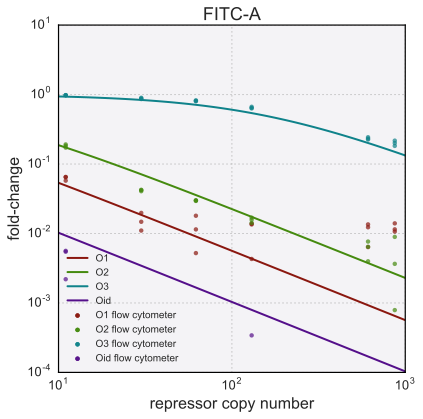

In [31]:
# define variables to use over the script
date = 20160725
username = 'mrazomej'

# read the CSV file with the mean fold change
df_preprocess = pd.read_csv('../../data/' + str(date) + '_lacI_titration_MACSQuant.csv',
                comment='#')
rbs = df_preprocess.rbs.unique()
replica = df_preprocess.replica.unique()

# compute the theoretical repression level
repressor_array = np.logspace(1, 3, 100)
epsilon_array = np.array([-15.3, -13.9, -9.7, -17])
operators = np.array(['O1', 'O2', 'O3', 'Oid'])

colors = sns.hls_palette(len(operators), l=.3, s=.8)
# plot theoretical curve
# First for the A channel
plt.figure(figsize=(6,6))
for i, o in enumerate(operators):
    fold_change_theor = 1 / (1 + 2 * repressor_array / 5E6 \
            * np.exp(-epsilon_array[i]))
    plt.plot(repressor_array, fold_change_theor, label=o,
            color=colors[i])
    plt.scatter(df_preprocess[(df_preprocess.operator == o) & \
                              (df_preprocess.rbs != 'auto') & \
            (df_preprocess.rbs != 'delta')].repressors, 
            df_preprocess[(df_preprocess.operator == o) & \
                          (df_preprocess.rbs != 'auto') & \
            (df_preprocess.rbs != 'delta')].fold_change_A,
            marker='o', linewidth=0, color=colors[i], 
            label=o + ' flow cytometer',
            alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('repressor copy number')
plt.ylabel('fold-change')
plt.title('FITC-A')
plt.xlim([10, 1E3])
plt.legend(loc='lower left')
plt.tight_layout()

It looks quite decent and It didn't involve choosing values for the thresholding criteria. The only parameter we set was the fraction $\alpha$ that we wantet to keep of the data.
Let's finally define a function that returns a thresholded `DataFrame`.

In [ ]:
def auto_gauss_gate(df, alpha, x_val='FSC-A', y_val='SSC-A', log=False):
    '''
    Function that applies an "unsupervised bivariate Gaussian gate" to the data
    over the channels x_val and y_val.
    
    Parameters
    ----------
    df : DataFrame.
        dataframe containing the data from which to fit the distribution
    alpha : float. [0, 1]
        fraction of data aimed to keep. Used to compute the chi^2 quantile function
    x_val, y_val : str.
        name of the dataframe columns to be used in the function
    log : bool.
        indicate if the log of the data should be use for the fit or not 
    '''
    data = df[[x_val, y_val]]
    # Fit the bivariate Gaussian distribution
    mu, cov = fit_2D_gaussian(data, log=log)

    # Compute the statistic for each of the pair of log scattering data
    interval_array = gauss_interval(data, mu, cov, log=log)
    
    # Find which data points fall inside the interval
    idx = interval_array <= scipy.stats.chi2.ppf(alpha, 2)
    
    return df[idx]

# Weighting each of the data points.

Rob had a good suggestion. He claims that we could try using the KDE density as a "weight" when computing the mean expression. If the KDE gives us the probability $P(FSC-A, SSC-A)$, i.e. the probability of obtaining a data point with certain values of front and side scattering, the outlier events would have a low probability compared to the real events and therefore would be weighted with a small number when computing the mean fluorescence as
\begin{equation}
\left\langle FITC-A \right\rangle = \sum_{i} P(FSC-A_i, SSC-A_i) \cdot FITC-A_i
\end{equation}

Let's see how that looks. In this case to compute the KDE we will use `scipy.stats` implementation of a Gaussian Kernel.

In [33]:
# Compute the KDE
kernel = scipy.stats.gaussian_kde([df_example['FSC-A'], df_example['SSC-A']])
prob = kernel([df_example['FSC-A'], df_example['SSC-A']])
np.sum(prob)

0.00050030737032958706